The problem was very interesting. This topic is very new to me and I have treated this exercise as a 24 hour hackathon. During my research, I stumbled upon the pymc-marketing library and found it best suited to this task. This notebook is not a testimony to my entire skillset, but rather a glimpse into what I can learn in a day.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytimetk as tk

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
import arviz as az

In [68]:
df = pd.read_csv('MMM_test_data.csv')
df

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,30-08-20,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,06-09-20,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,13-09-20,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,20-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,27-09-20,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48
...,...,...,...,...,...,...,...,...,...
99,24-07-22,72021.50,0.00,1118.78,22305.10,4566.01,2987.70,0.00,19916.88
100,31-07-22,90786.21,0.00,122.16,15812.65,4795.51,3293.40,0.00,22687.98
101,07-08-22,105929.40,0.00,754.09,12166.85,4961.12,4057.03,0.00,30142.64
102,14-08-22,90506.31,0.00,1043.22,10856.58,4431.13,3086.81,0.00,28622.78


In the next few cells, I do some sanity checks, look for outliers or missing data. I also make sure that the datatypes are right to be used in the MMM model later. I engineer some basic features wherever possible

In [69]:
df.describe()

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,136490.190673,1245.604808,343.640962,19507.177981,6915.136731,8575.611442,5063.699038,27701.367404
std,50810.253012,1388.384632,332.988218,8714.759886,3123.172035,6956.787524,6689.472660,12176.293684
min,63207.090000,0.000000,4.370000,5938.130000,3602.200000,747.460000,0.000000,9391.210000
25%,101675.685000,334.275000,120.470000,13879.000000,5113.937500,2902.032500,0.000000,19797.710000
50%,128790.460000,856.870000,202.020000,17929.450000,6194.400000,6879.270000,2423.095000,24248.640000
75%,157707.280000,1658.032500,553.075000,22252.262500,7470.557500,14367.582500,8701.960000,33852.652500
max,418186.380000,8513.830000,1605.850000,49689.380000,22629.690000,33009.650000,33692.830000,77488.420000


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   start_of_week    104 non-null    object 
 1   revenue          104 non-null    float64
 2   spend_channel_1  104 non-null    float64
 3   spend_channel_2  104 non-null    float64
 4   spend_channel_3  104 non-null    float64
 5   spend_channel_4  104 non-null    float64
 6   spend_channel_5  104 non-null    float64
 7   spend_channel_6  104 non-null    float64
 8   spend_channel_7  104 non-null    float64
dtypes: float64(8), object(1)
memory usage: 7.4+ KB


In [71]:
# Convert to datetime with day-first format
df['start_of_week'] = pd.to_datetime(df['start_of_week'], format='%d-%m-%y')

# Extract date parts
df['Year'] = df['start_of_week'].dt.year
df['Month'] = df['start_of_week'].dt.month
df['Day_of_year'] = df['start_of_week'].dt.dayofyear

# Week of the month
def week_of_month(dt):
    first_day = dt.replace(day=1)
    adjusted_dom = dt.day + first_day.weekday()  # Align to first week's weekday
    return int(np.ceil(adjusted_dom / 7.0))

df['Week_of_month'] = df['start_of_week'].apply(week_of_month)

# Create a trend column from the index position
df['trend'] = range(len(df))


# Reorder columns
new_cols = ['start_of_week', 'Year', 'Month', 'Day_of_year', 'Week_of_month','trend']
other_cols = [col for col in df.columns if col not in new_cols and col != 'revenue']
df = df[new_cols + other_cols + ['revenue']]

# Convert to datetime64[ns] for consistency
df['start_of_week'] = df['start_of_week'].astype('datetime64[ns]')
df.rename(columns={'start_of_week': 'date'}, inplace=True)




In [72]:

df

,date,Year,Month,Day_of_year,Week_of_month,trend,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,revenue
0,2020-08-30,2020,8,243,5,0,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79,157906.75
1,2020-09-06,2020,9,250,1,1,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45,186425.68
2,2020-09-13,2020,9,257,2,2,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05,161607.39
3,2020-09-20,2020,9,264,3,3,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73,180089.13
4,2020-09-27,2020,9,271,4,4,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48,217793.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2022-07-24,2022,7,205,4,99,0.00,1118.78,22305.10,4566.01,2987.70,0.00,19916.88,72021.50
100,2022-07-31,2022,7,212,5,100,0.00,122.16,15812.65,4795.51,3293.40,0.00,22687.98,90786.21
101,2022-08-07,2022,8,219,1,101,0.00,754.09,12166.85,4961.12,4057.03,0.00,30142.64,105929.40
102,2022-08-14,2022,8,226,2,102,0.00,1043.22,10856.58,4431.13,3086.81,0.00,28622.78,90506.31


I perform some EDA to understand the data better. The aim of this step is to see if there are any noticeable trends or outliers over time.

In [73]:
# 1.0 EXPLORATORY DATA ANALYSIS

# Convert all column names to lowercase
df.columns = [col.lower() for col in df.columns]
df.columns

Index(['date', 'year', 'month', 'day_of_year', 'week_of_month', 'trend',
       'spend_channel_1', 'spend_channel_2', 'spend_channel_3',
       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
       'spend_channel_7', 'revenue'],
      dtype='object')

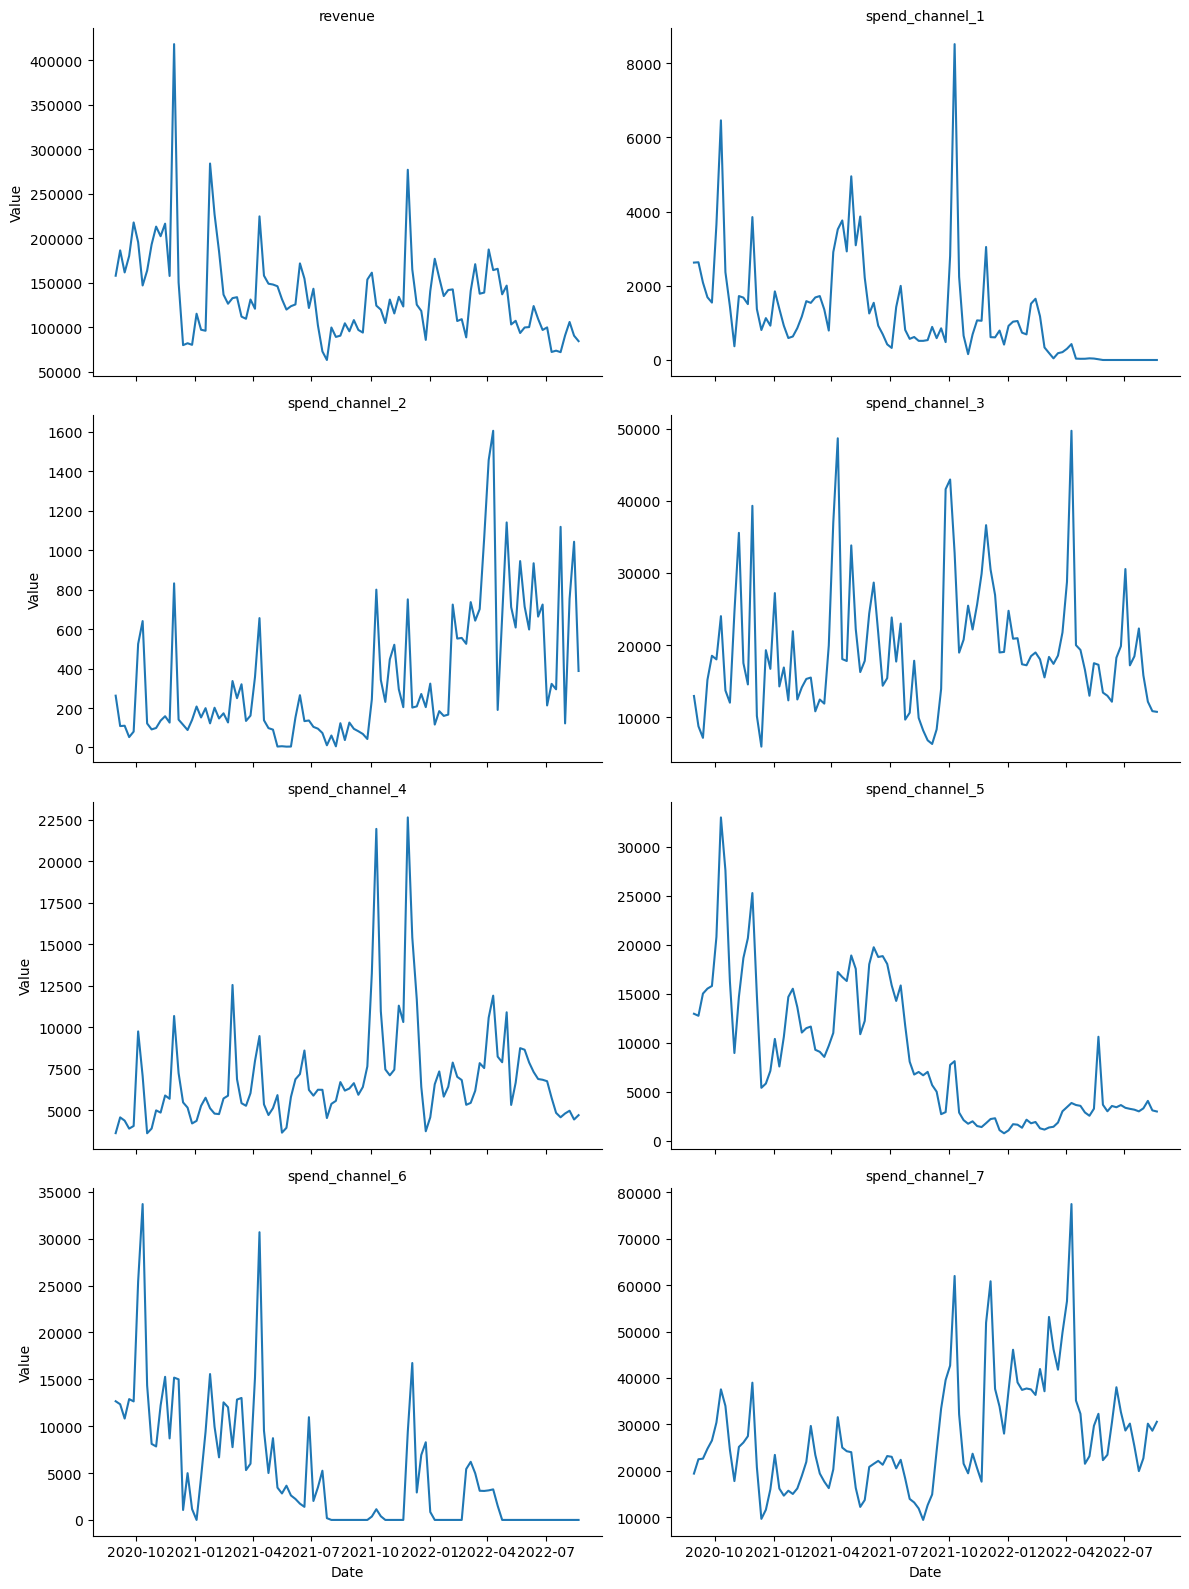

In [74]:
df_melted = df.melt(
    id_vars="date",
    value_vars=[
        'revenue', 'spend_channel_1', 'spend_channel_2', 'spend_channel_3',
       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
       'spend_channel_7'
    ],
    var_name="variable",
    value_name="value"
)

# Ensure 'date' is datetime
df_melted['date'] = pd.to_datetime(df_melted['date'])

# Set up Seaborn FacetGrid
g = sns.FacetGrid(df_melted, col="variable", col_wrap=2, height=4, aspect=1.5, sharey=False)
g.map(sns.lineplot, "date", "value")

# Improve layout
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Date", "Value")
plt.tight_layout()
plt.show()

Window 7: Avg. Abs Correlation = 0.5003
Window 14: Avg. Abs Correlation = 0.4501
Window 21: Avg. Abs Correlation = 0.4251
Window 30: Avg. Abs Correlation = 0.4023
Window 45: Avg. Abs Correlation = 0.3947
Window 60: Avg. Abs Correlation = 0.3589

✅ Best window size: 7 (Avg. Abs Corr: 0.5003)


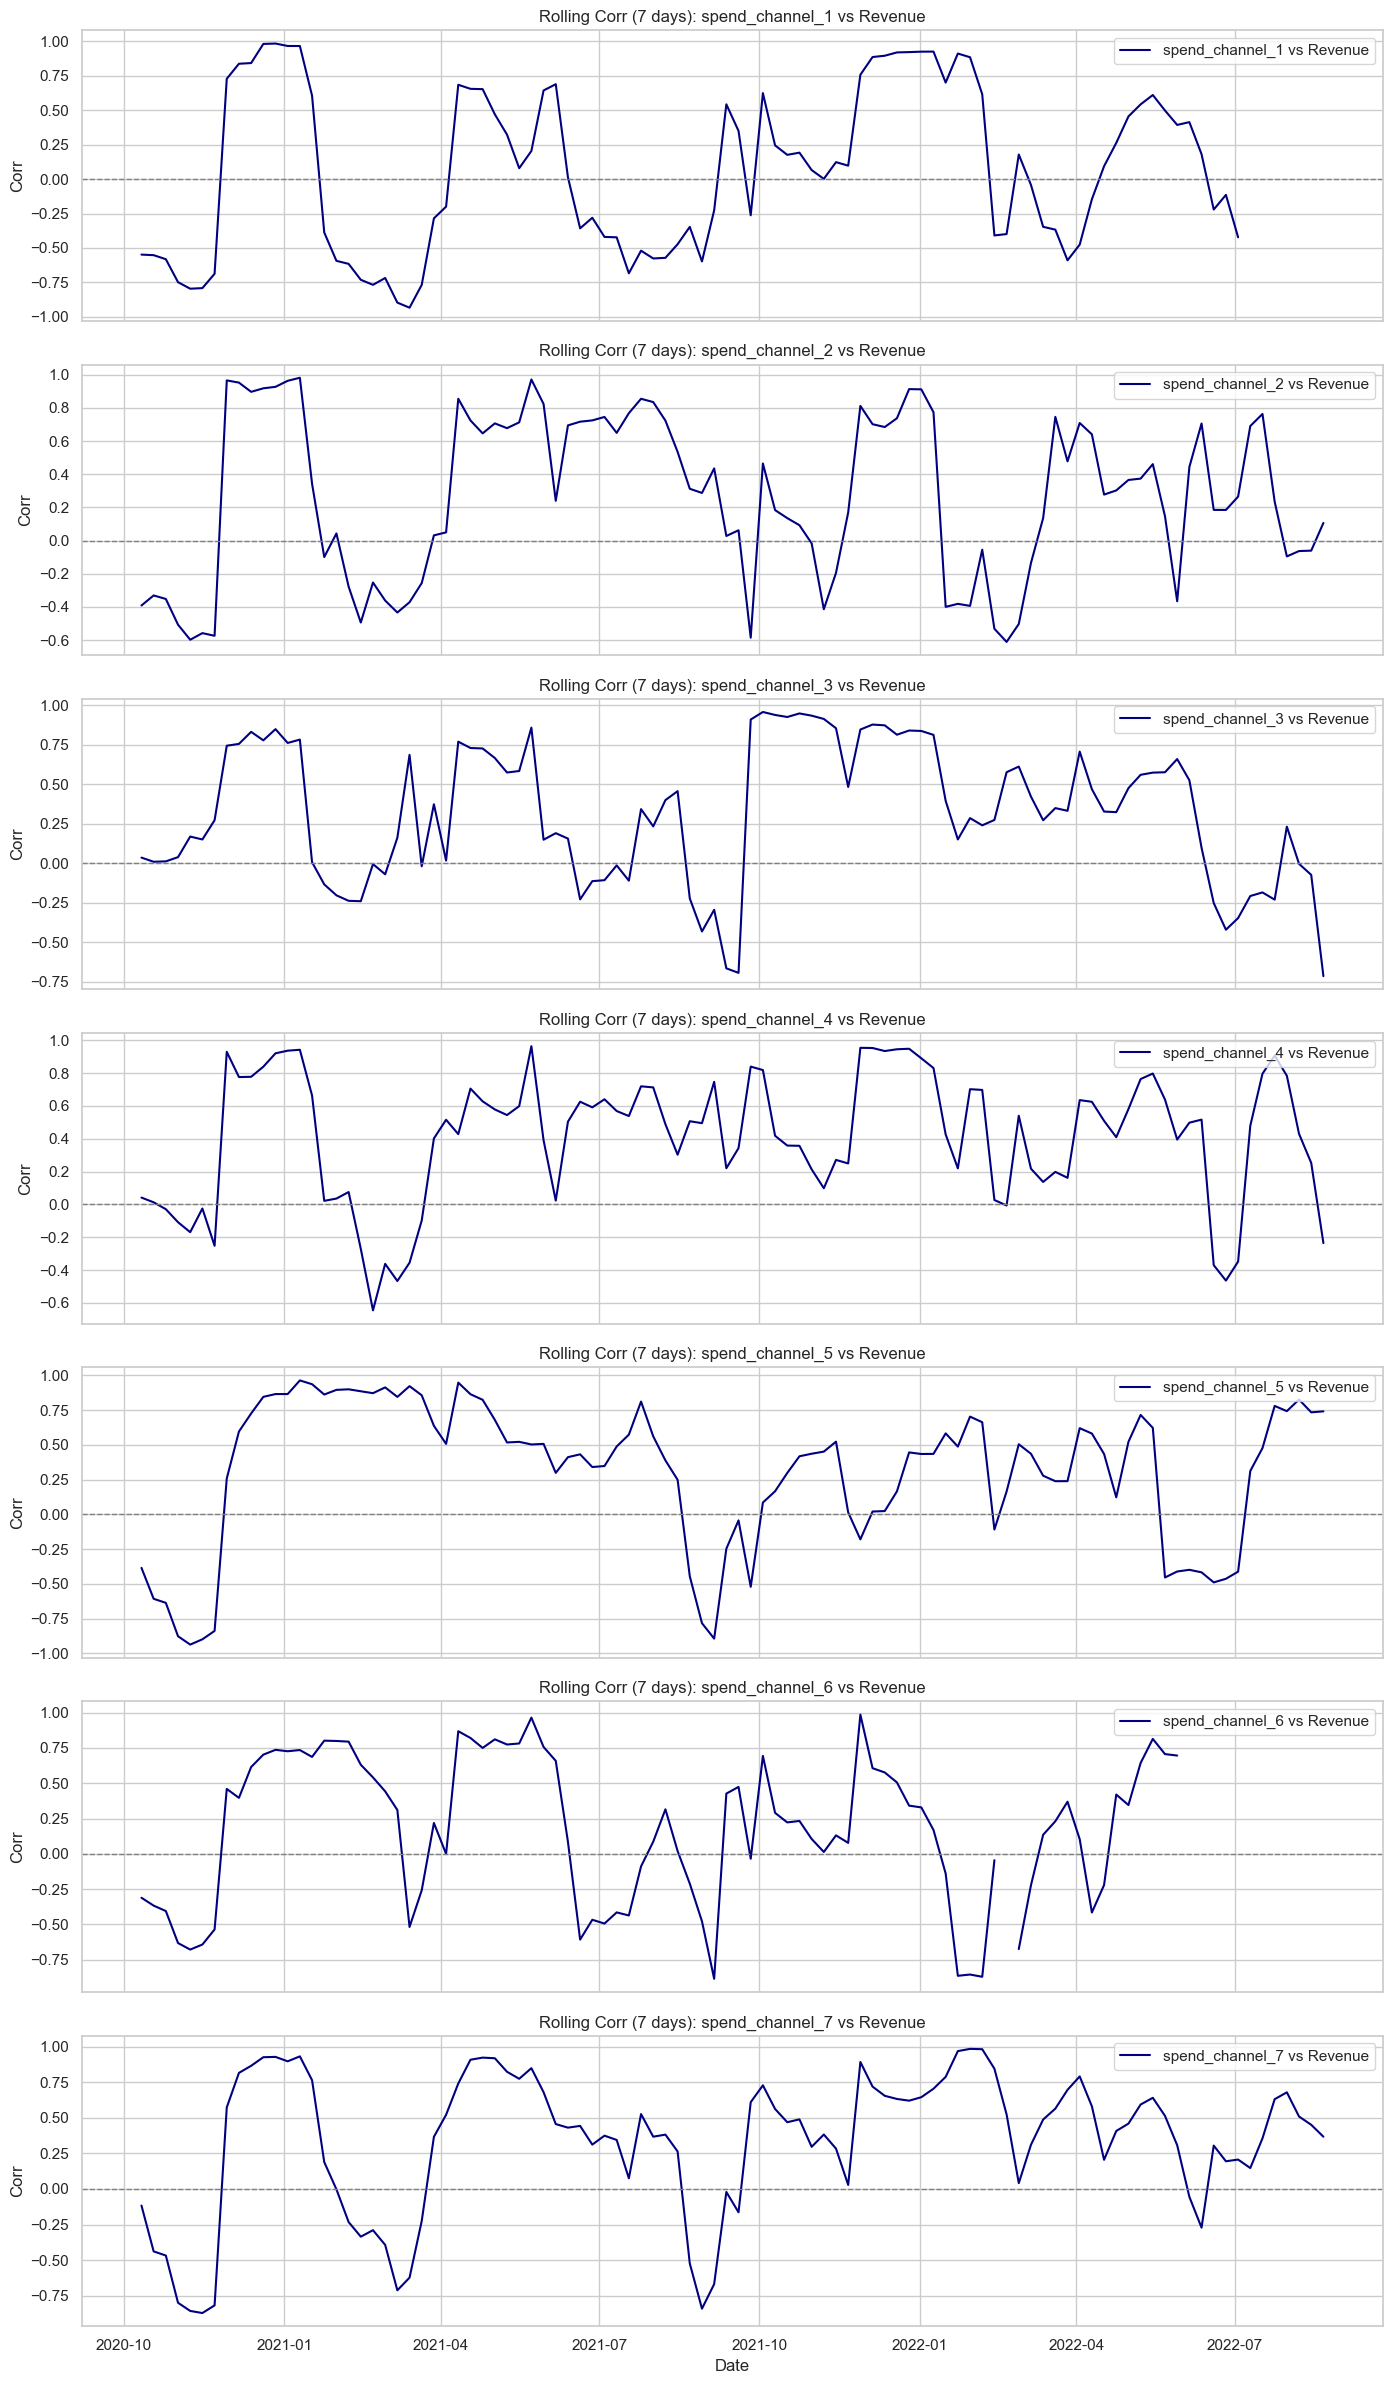

In [79]:
# Optional: Set seaborn style
sns.set(style="whitegrid")

# Sort the DataFrame by date
df = df.sort_values(by='date')

# List of spend channels
spend_channels = [f'spend_channel_{i}' for i in range(1, 8)]

# Try multiple window sizes
window_options = [7, 14, 21, 30, 45, 60]
best_window = None
best_score = -np.inf

# Evaluate each window
for window in window_options:
    total_corr = 0
    count = 0
    for channel in spend_channels:
        rolling_corr = df[channel].rolling(window=window).corr(df['revenue'])
        avg_abs_corr = rolling_corr.abs().mean(skipna=True)
        if not np.isnan(avg_abs_corr):
            total_corr += avg_abs_corr
            count += 1
    avg_score = total_corr / count if count else 0
    print(f"Window {window}: Avg. Abs Correlation = {avg_score:.4f}")
    
    if avg_score > best_score:
        best_score = avg_score
        best_window = window

print(f"\n✅ Best window size: {best_window} (Avg. Abs Corr: {best_score:.4f})")

# ---------- PLOT WITH BEST WINDOW ----------
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(14, 24), sharex=True)

for i, channel in enumerate(spend_channels):
    rolling_corr = df[channel].rolling(window=best_window).corr(df['revenue'])
    
    axes[i].plot(df['date'], rolling_corr, label=f'{channel} vs Revenue', color='navy')
    axes[i].axhline(0, color='gray', linestyle='--', linewidth=1)
    axes[i].set_title(f'Rolling Corr ({best_window} days): {channel} vs Revenue', fontsize=12)
    axes[i].legend(loc='upper right')
    axes[i].set_ylabel('Corr')

plt.xlabel('Date')
plt.tight_layout()
plt.show()


From the graph above, I am trying to find the best adstock(spend carry over effect) using rolling pearson correlation between a spend channel and revenue over a moving window. I have experimented with different moving window values to come up with the best value, which turns out to be the lowest value that we have specified, which is 7. We can see positive correlation which means that our marketing spends have a direct positive effect on the revenue.

In [45]:

# Total Spend and Revenue Analysis
total_spend = df[['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
       'spend_channel_7']].sum(axis=0).sum()
total_revenue = df["revenue"].sum()

total_revenue/total_spend


np.float64(1.9680718876580992)

In [46]:
# Monthly Ad Spend Analysis

median_spend = df[['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
                     'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
                     'spend_channel_7']].median()
median_spend


spend_channel_1      856.870
spend_channel_2      202.020
spend_channel_3    17929.450
spend_channel_4     6194.400
spend_channel_5     6879.270
spend_channel_6     2423.095
spend_channel_7    24248.640
dtype: float64

In [47]:

mean_spend = df[['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
                     'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
                     'spend_channel_7']].mean()
mean_spend

spend_channel_1     1245.604808
spend_channel_2      343.640962
spend_channel_3    19507.177981
spend_channel_4     6915.136731
spend_channel_5     8575.611442
spend_channel_6     5063.699038
spend_channel_7    27701.367404
dtype: float64

In [48]:

df[['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
       'spend_channel_7']] \
    .describe() \
    .apply(lambda x: x.apply(lambda y: "{:.0f}".format(y)))

,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
count,104,104,104,104,104,104,104
mean,1246,344,19507,6915,8576,5064,27701
std,1388,333,8715,3123,6957,6689,12176
min,0,4,5938,3602,747,0,9391
25%,334,120,13879,5114,2902,0,19798
50%,857,202,17929,6194,6879,2423,24249
75%,1658,553,22252,7471,14368,8702,33853
max,8514,1606,49689,22630,33010,33693,77488


In [50]:
df_features = df[['date', 'year', 'month', 'day_of_year', 'week_of_month', 'trend',
       'spend_channel_1', 'spend_channel_2', 'spend_channel_3',
       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
       'spend_channel_7','revenue']]

In the next step, we try to incorporate prior knowledge into the model. We start with a simple heuristic. We assume that the channel contributions should be positive, going by the correlation plots we saw previously. So we go for a HalfNormal distribution as prior. We need to set the sigma parameter per channel. The higher the sigma, the more “freedom” it has to fit the data. To specify sigma we can use the following point. We expect channels where we spend the most to have more attributed sales , before seeing the data. This is a very reasonable assumption.


MMM class scales the target and input variables through an MaxAbsScaler transformer from scikit-learn, its important to specify the priors in the scaled space (i.e. between 0 and 1). One way to do it is to use the spend share as the sigma parameter for the HalfNormal distribution. We can actually add a scaling factor to take into account the support of the distribution.

In [80]:
# 3.0 MODEL SET UP ----
# Reference: https://www.pymc-marketing.io/en/stable/notebooks/mmm_example.html#id1
# - DelayedSaturatedMMM handles scaling transformations internally
# - Uses MaxAbsScaler transformer from scikit-learn
# - Specify the priors in the scaled space (i.e. between 0 and 1)
# - One way to do it is to use spend / max(spend) as the prior



# 🌻 Create Priors from Business Knowledge
total_spend_per_channel = df_features[['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
       'spend_channel_7']].sum(axis=0)

spend_proportion = total_spend_per_channel / total_spend_per_channel.sum()

HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

n_channels = 7

prior_sigma = HALFNORMAL_SCALE * n_channels * spend_proportion

prior_sigma.tolist()

[0.208562962412245,
 0.05753893731145437,
 3.2662645510414174,
 1.157864350834477,
 1.4358927613788164,
 0.8478612684404919,
 4.638292348373241]

Although it is possible to use priors based on business knowledge, after some experimentation , I go with the default priors

In [82]:

# 🛠️ Create a Model Specification
X = df_features.drop("revenue", axis=1)
y = df_features["revenue"]


# Customizing the Model Configuration
my_model_config = {
    'intercept': {
        'dist': 'Normal',
        'kwargs': {
            'mu': 0,
            'sigma': 2
        }
    },
    'beta_channel': {
        'dist': 'HalfNormal',
        'kwargs': {
            'sigma': 2
        }
    },
    # 'beta_channel1': {
    #     'dist': 'LogNormal',
    #     'kwargs': {
    #         'mu': np.array([5, 11]),
    #         'sigma': prior_sigma_to_dummy()
    #     }
    # },
    "likelihood": {
        "dist": "Normal",
        "kwargs": {
            "sigma": {
                "dist": "HalfNormal",
                "kwargs": { "sigma": 2 }
            }
        }
    },
    "alpha": {
        "dist": "Beta",
        "kwargs": { "alpha": 1, "beta": 3 }
    },
    "lam": {
        "dist": "Gamma",
        "kwargs": { "alpha": 3, "beta": 1 }
    },
    "gamma_control": {
        "dist": "Normal",
        "kwargs": { "mu": 0, "sigma": 2 }
    },
    "gamma_fourier": {
        "dist": "Laplace",
        "kwargs": { "mu": 0, "b": 1 }
    },
}



In [ ]:
# DelayedSaturatedMMM Model1


# my_sampler_config: {
#     "progressbar": True,
#     "cores": 1
# }

mmm = MMM(
    model_config = my_model_config,
    saturation=LogisticSaturation(),
    date_column = "date",
    channel_columns = ['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
       'spend_channel_7'],
    control_columns = [
        "trend",
        "year",
        "month",
        "day_of_year",
        "week_of_month",
    ],
    adstock=GeometricAdstock(l_max=8),
    yearly_seasonality=2,
)

mmm.model_config

mmm.default_model_config


{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

In [59]:
# 4.0 MODEL FITTING
# - Model fitting (takes 20 minutes with 1 core)

# Fit the Model
mmm.fit(X, y, target_accept = 0.95, random_seed = 888)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1409 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [62]:

# Production Model Storage and Retrieval
mmm.save("model/mmm_adspend_model_wed_night.pkl")

In [65]:

#loaded_mmm = MMM.load("model/mmm_adspend_model_wed_night.pkl")

loaded_mmm = mmm
# Model Summary (arviz object)
loaded_mmm.idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [66]:
# Number of diverging samples
loaded_mmm.idata["sample_stats"]["diverging"].sum().item()

0

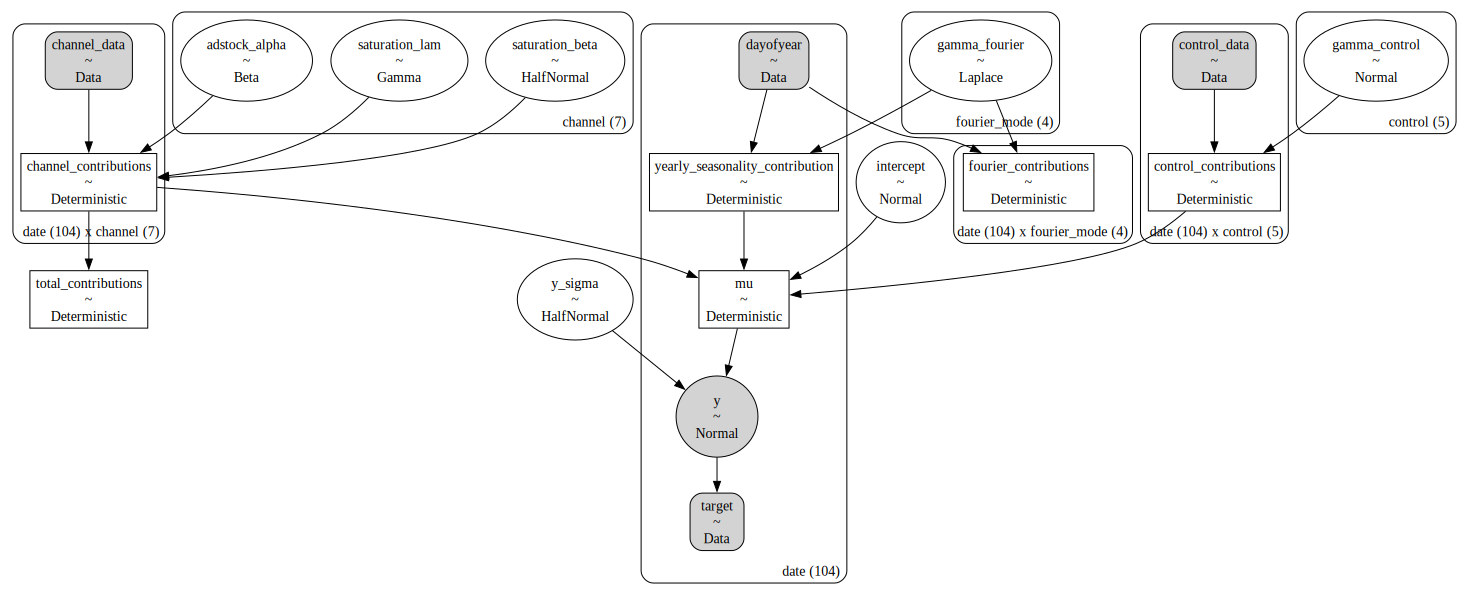

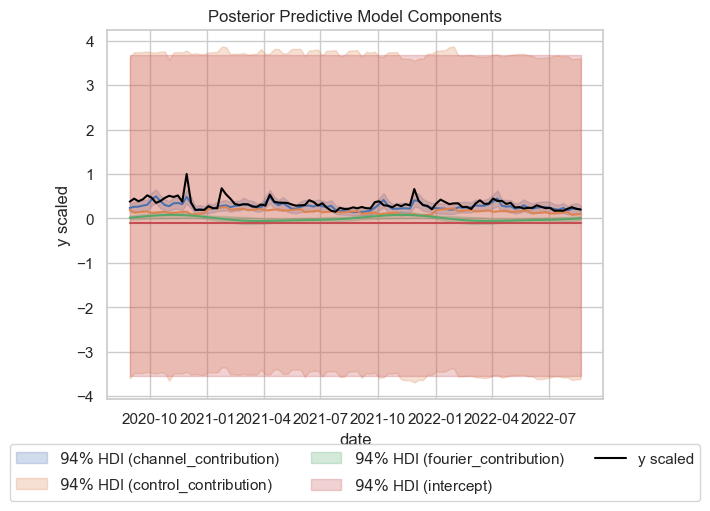

In [84]:

# 5.0 POST MODEL ANALYSIS & VISUALIZATIONS -----

# Plot Components Contributions
fig = loaded_mmm.plot_components_contributions()

# Plot Graphical MMM Model
fig = loaded_mmm.graphviz()
fig


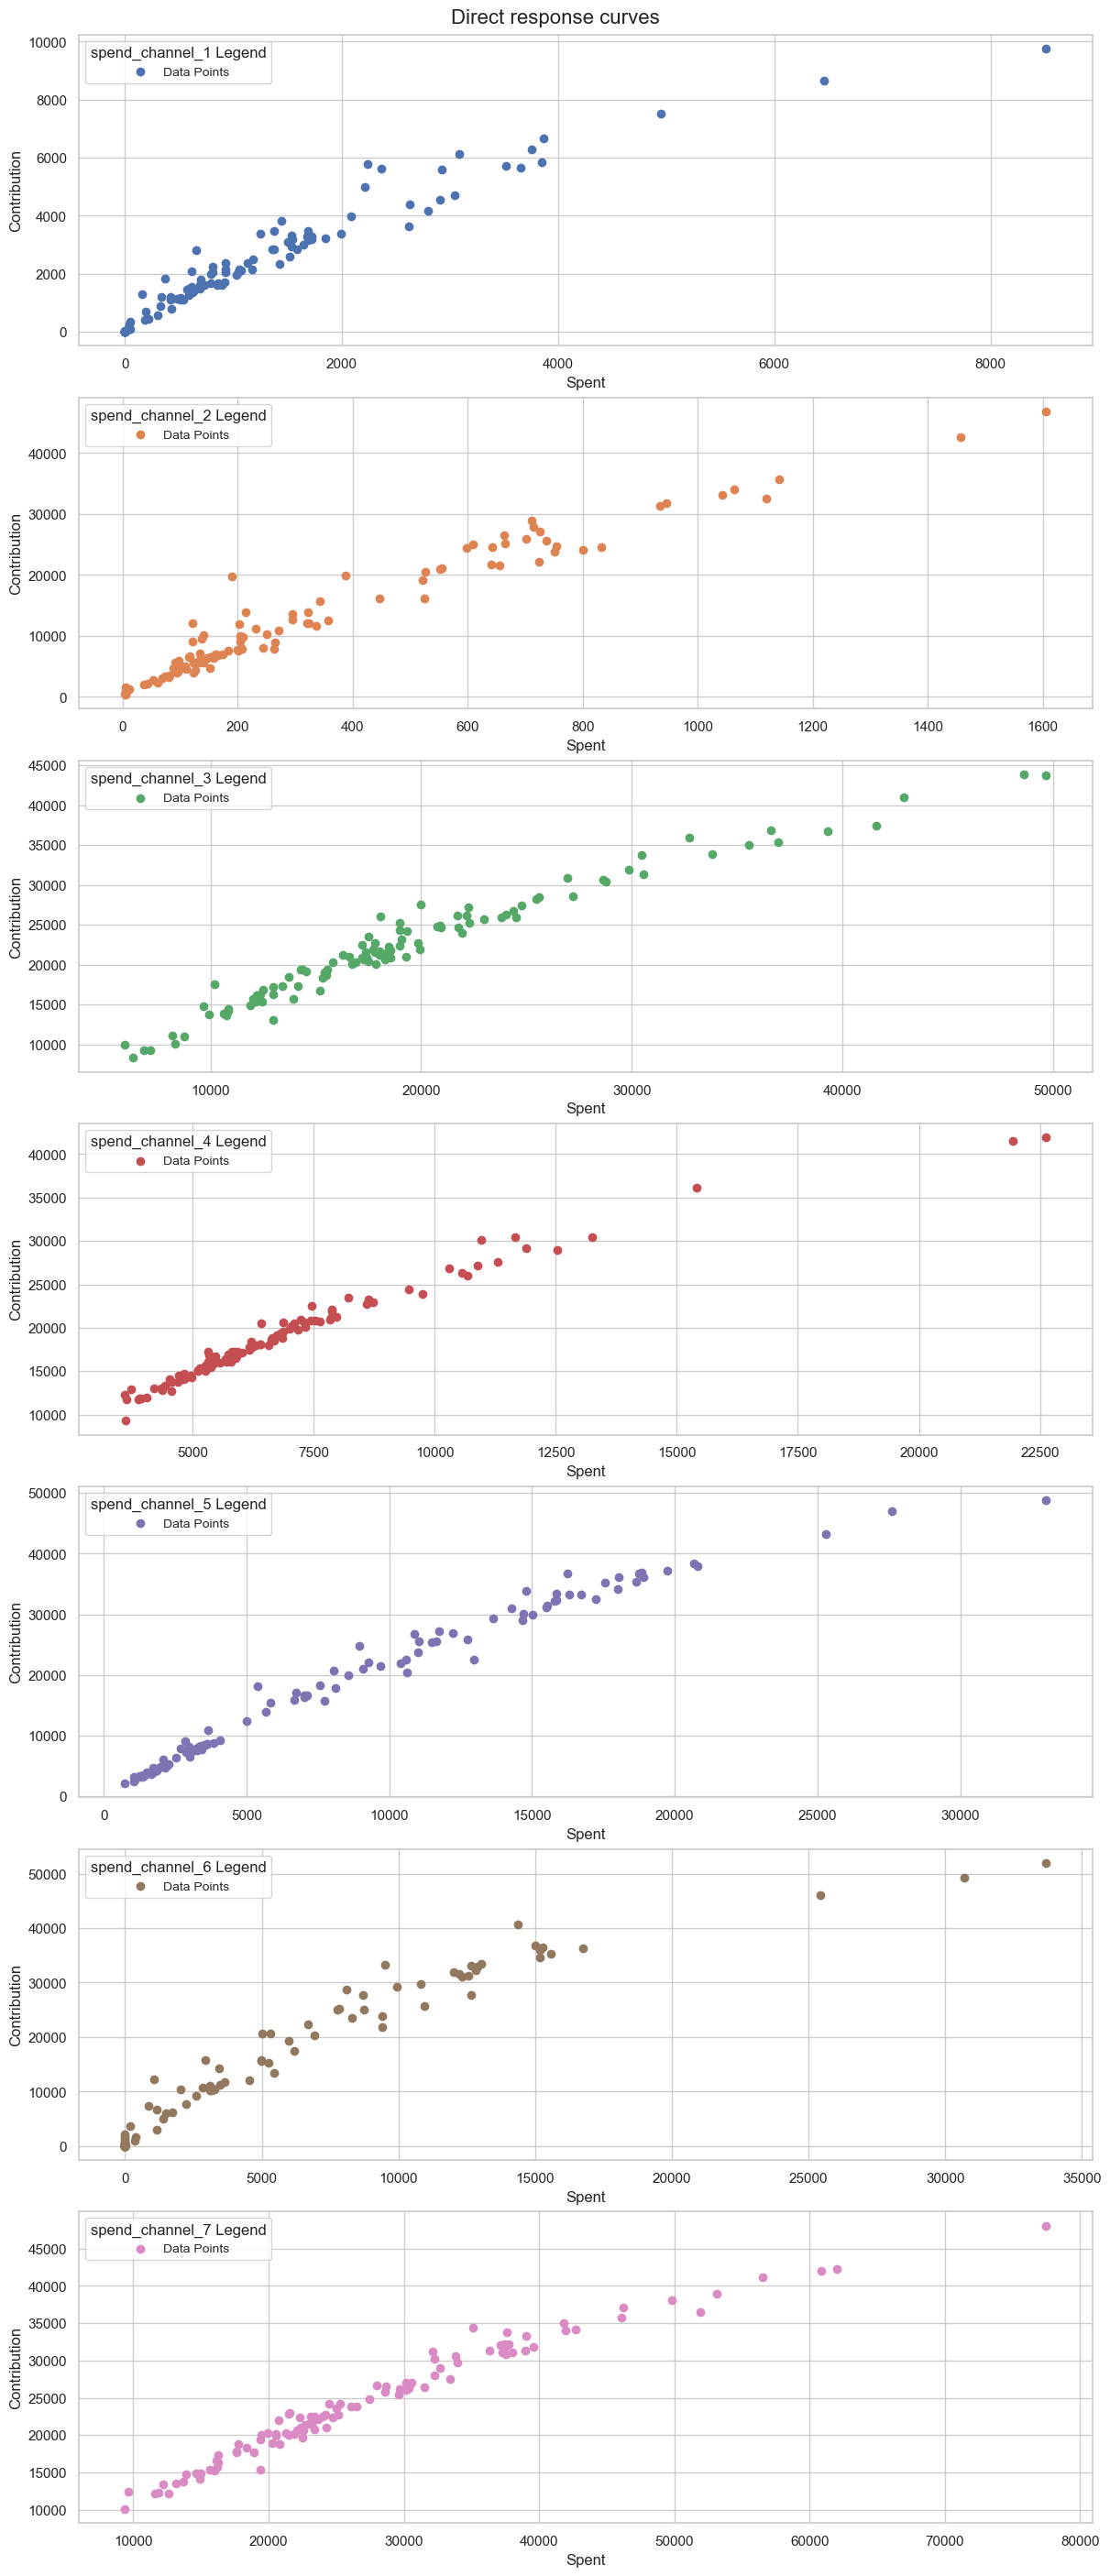

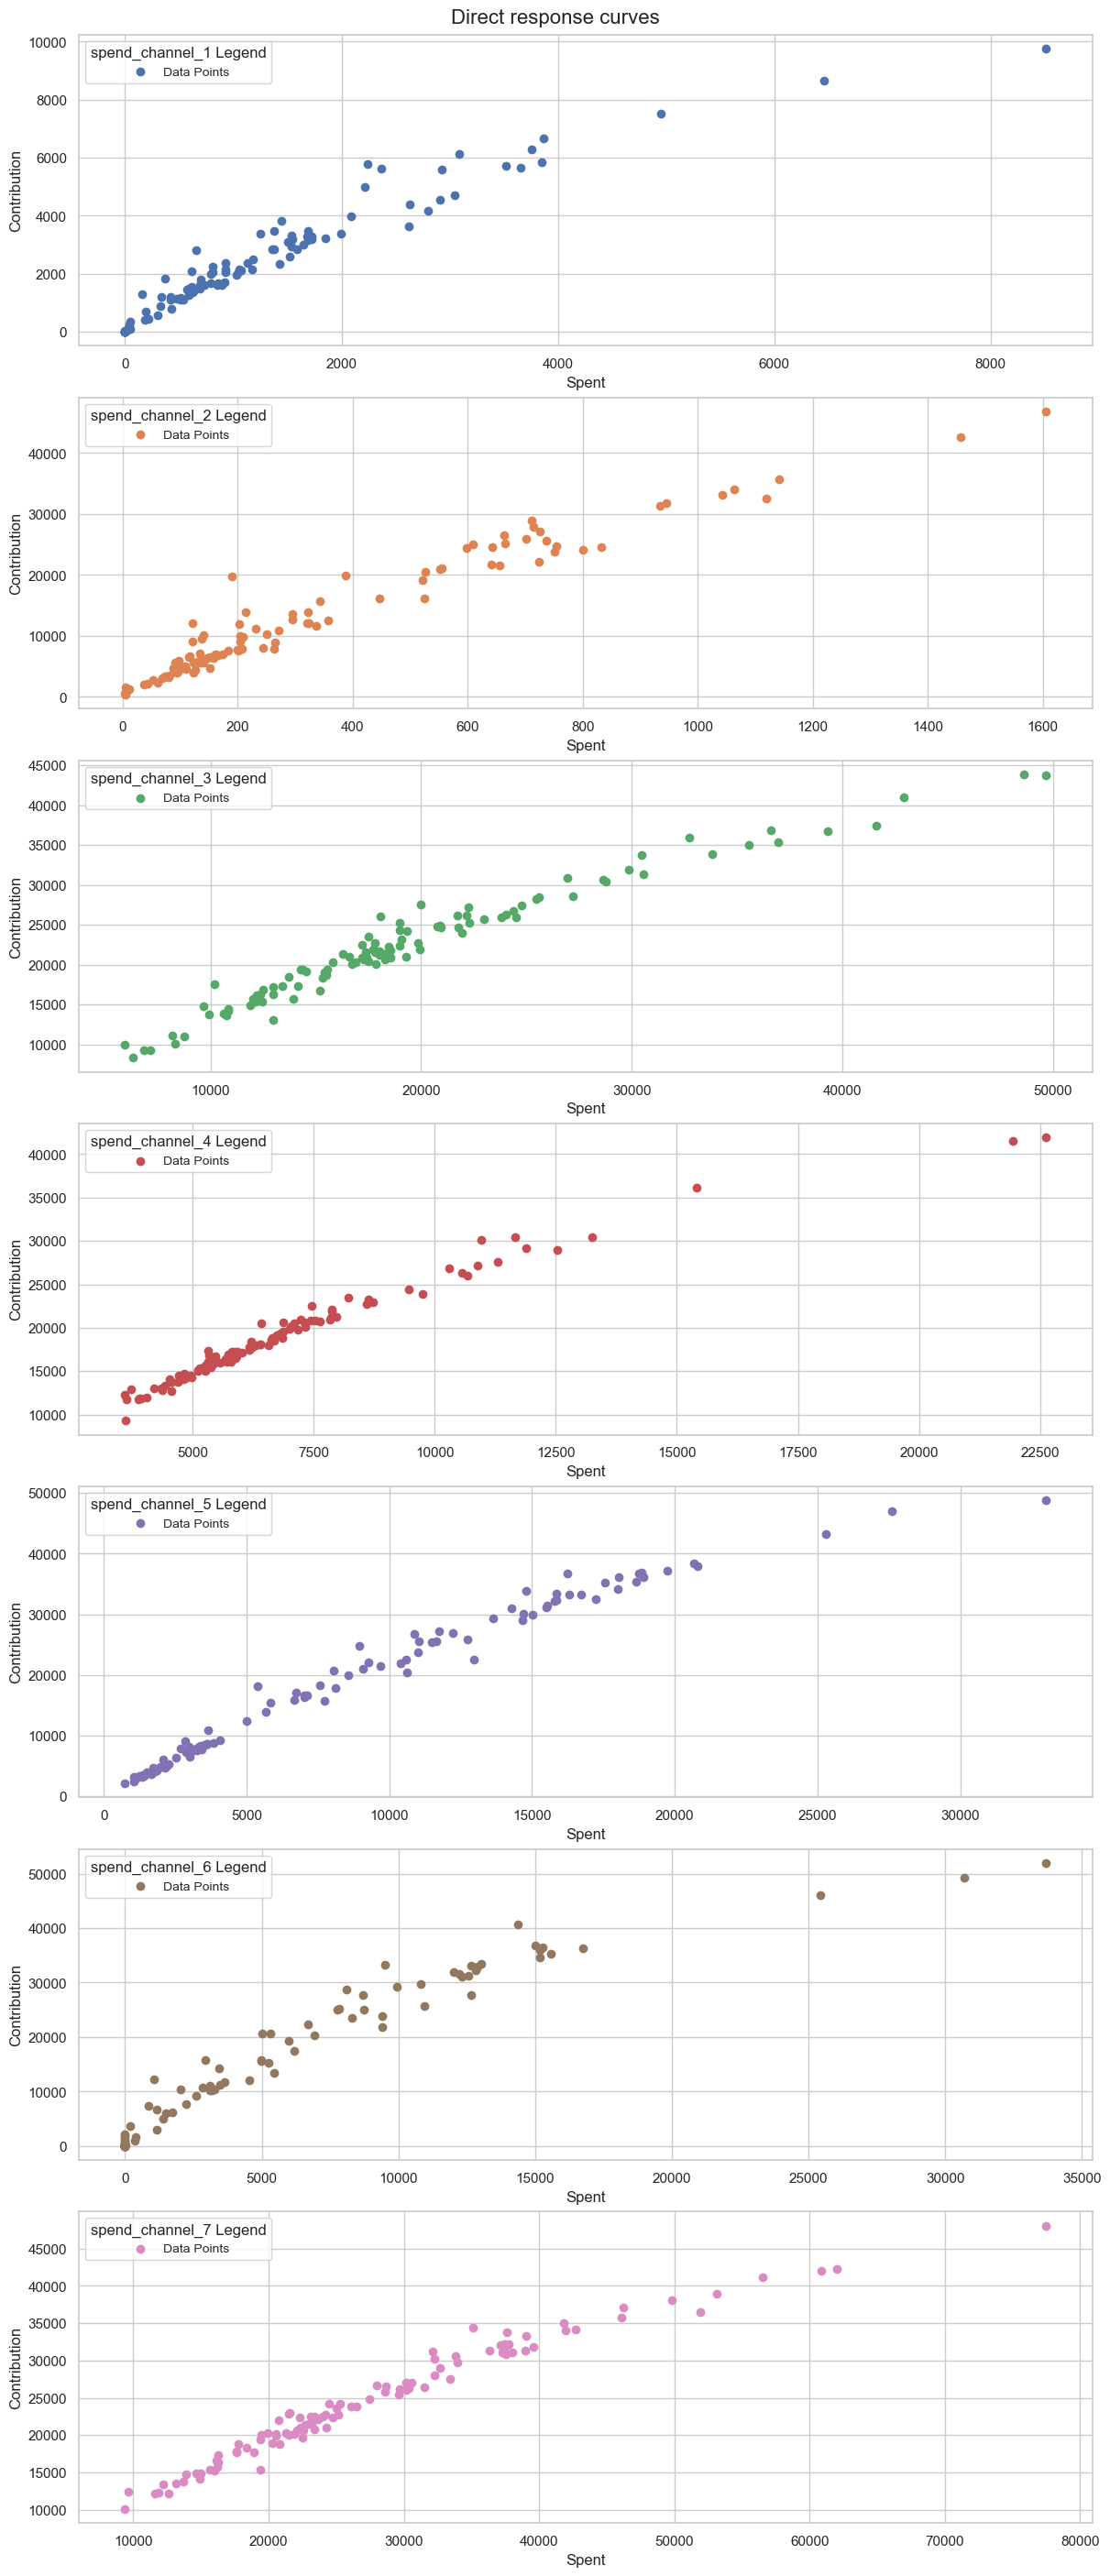

In [85]:
# Plot Direct Contribution Curves
fig = loaded_mmm.plot_direct_contribution_curves()
fig

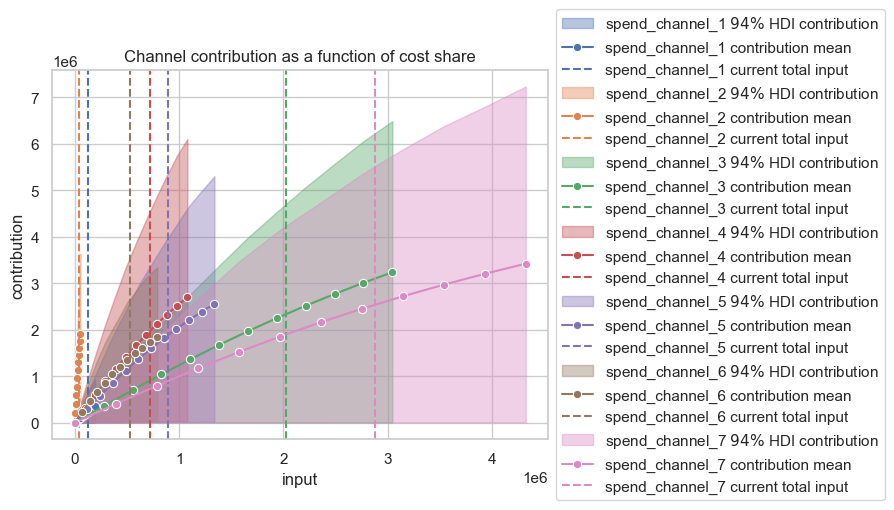

In [86]:

# Plot Channel Contributions
# Takes a bit to run
fig = loaded_mmm.plot_channel_contributions_grid(start=0, 
                                                 stop=1.5, num=12, absolute_xrange=True)


In [96]:
# List of coefficient names based on your model definition
channel_names = [f'spend_channel_{i}' for i in range(1, 8)]

# Extract posterior samples for each coefficient
posterior = loaded_mmm.posterior  # xarray dataset

print(loaded_mmm.posterior.data_vars)

Data variables:
    intercept                        (chain, draw) float64 16kB -3.399 ... 2.144
    gamma_control                    (chain, draw, control) float64 80kB 0.00...
    gamma_fourier                    (chain, draw, fourier_mode) float64 64kB ...
    adstock_alpha                    (chain, draw, channel) float64 112kB 0.0...
    saturation_lam                   (chain, draw, channel) float64 112kB 0.5...
    saturation_beta                  (chain, draw, channel) float64 112kB 0.0...
    y_sigma                          (chain, draw) float64 16kB 0.08545 ... 0...
    channel_contributions            (chain, draw, date, channel) float64 12MB ...
    total_contributions              (chain, draw) float64 16kB 46.26 ... 27.64
    control_contributions            (chain, draw, date, control) float64 8MB ...
    fourier_contributions            (chain, draw, date, fourier_mode) float64 7MB ...
    yearly_seasonality_contribution  (chain, draw, date) float64 2MB 0.01607 ...
   

In [103]:
channel_contrib.channel

<xarray.DataArray 'channel' (channel: 7)> Size: 420B
array(['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
       'spend_channel_7'], dtype='<U15')
Coordinates:
  * channel  (channel) <U15 420B 'spend_channel_1' ... 'spend_channel_7'

In [87]:

# 6.0 BUSINESS APPLICATIONS: RETURN ON ADSPEND

# Estimate Return on Ad Spend (ROAS) by Channel

get_mean_contributions_over_time_df = loaded_mmm.compute_mean_contributions_over_time(original_scale=True)

channel_contribution_original_scale = loaded_mmm.compute_channel_contribution_original_scale()

roas_samples = (
    channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")
    / X[['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
       'spend_channel_7']].sum().to_numpy()[:, None]
)


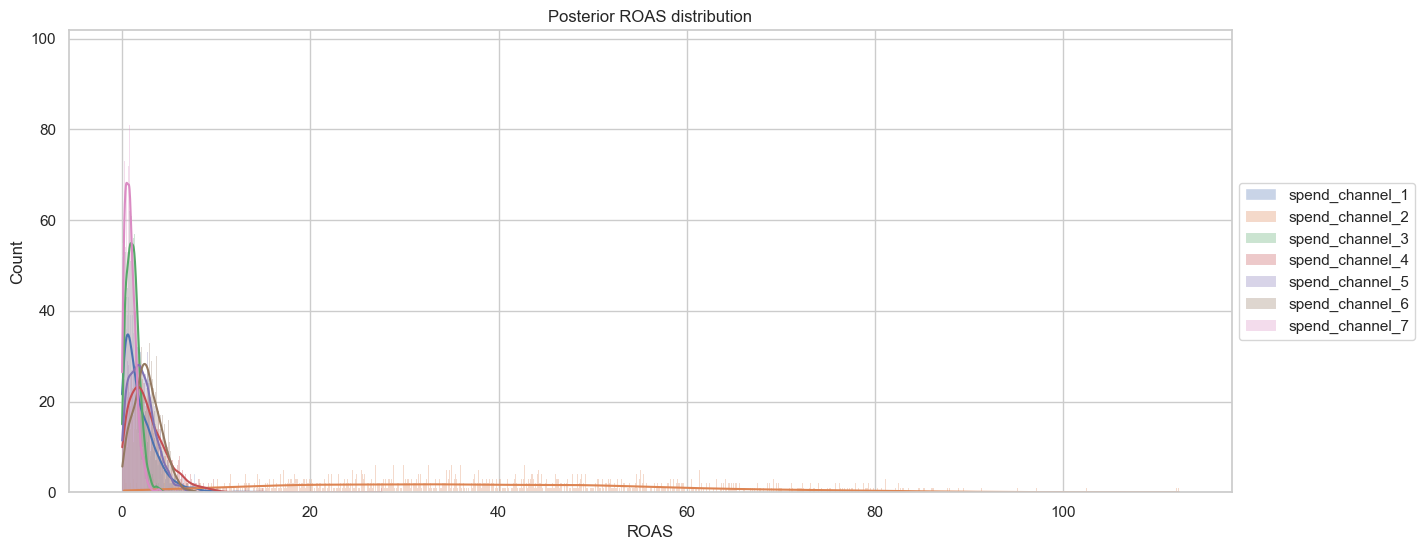

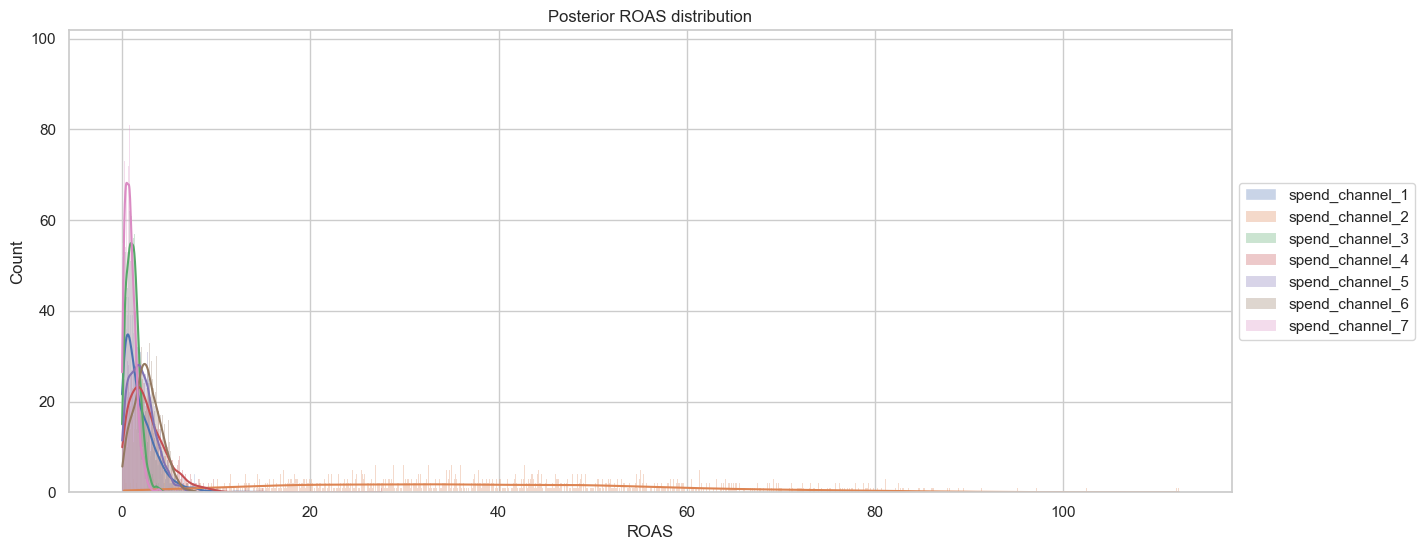

In [88]:
# Visualize Estimated ROAS by Channel
fig, ax = plt.subplots(figsize=(15, 6))
for channel in ['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
       'spend_channel_7']:
    sns.histplot(
        roas_samples.sel(channel=channel).to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax, legend=True, label=channel
    )

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS")
fig

In [89]:

# ROAS Summary
roas_df = roas_samples.to_dataframe(name="roas")

roas_df.groupby("channel").mean()

roas_df.groupby("channel")["roas"].describe(percentiles=[0.025, 0.975])


,count,mean,std,min,2.5%,50%,97.5%,max
channel,,,,,,,,
spend_channel_1,2000.0,1.889800,1.818500,0.000830,0.050315,1.339994,6.607737,15.397358
spend_channel_2,2000.0,37.735313,20.463705,0.198034,3.537692,35.987742,80.611930,112.292117
spend_channel_3,2000.0,1.152397,0.701987,0.000522,0.092522,1.078436,2.790184,4.463989
spend_channel_4,2000.0,2.737269,2.109169,0.017877,0.174870,2.306396,7.846869,27.584172
spend_channel_5,2000.0,2.109300,1.366386,0.013781,0.126343,1.931692,5.202000,8.485846
spend_channel_6,2000.0,2.651086,1.410478,0.025618,0.282844,2.550307,5.628365,7.805063
spend_channel_7,2000.0,0.881316,0.622493,0.000416,0.053898,0.779910,2.366379,5.834024


## Questions

## How do you model spend carry over?

Although Rolling Pearson coefficients are good to visualize the adstock effect, it is only descriptive and not causal. The right way to model this is to perform adstock transformation

## Explain your choice of prior inputs to the model?
Assuming all channel contributions are positive, we have used a HalfNormal distribution as prior. We have used spend share as the scaled sigma parameter to our HalfNormal distribution. 

## How are your model results based on prior sampling vs. posterior sampling?
I don't know how to answer this question.

## How good is your model performing? How you do measure it?
We checked for divergent transitions during posterior sampling. It gives a value of 0, which means there are no divergences and posterior sampling went smoothly.

## What are your main insights in terms of channel performance/ effects?
Channeil_2 seems to be the best performer. It is possible to plot the ROAS values and also determine the coefficient and decay rate of each channel to answer this question better.